# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    dff = df.copy()
    
    first=True
    
    for col in dff.filter(regex='[0-9]_CPM').columns:
        
        col_gene_name = col.split("_CP")[0] + "_total_gene_CPM"
        col_relative_abundance = col.split("_CP")[0] + "_relative_abundance"
    
        dff_sums = dff[["gene_id", col]].groupby("gene_id").sum()

        dff_sums[col_gene_name] = dff_sums[col].copy()

        dff_sums.drop(columns=col, inplace=True)

        if first:
            merged_dff = pd.merge(dff, dff_sums, how='inner', on="gene_id")
            merged_dff[col_relative_abundance] = ((merged_dff[col]/merged_dff[col_gene_name]) * 100)
            
        else:
            merged_dff = pd.merge(merged_dff, dff_sums, how='inner', on="gene_id")
            merged_dff[col_relative_abundance] = ((merged_dff[col]/merged_dff[col_gene_name]) * 100)
        
        first=False
        
    for col_count in merged_dff.filter(regex='[0-9]_count').columns:
        
        col_gene_name = col_count.split("_count")[0] + "_total_gene_counts"
        
        dff_sums = merged_dff[["gene_id", col_count]].groupby("gene_id").sum()
        dff_sums[col_gene_name] = dff_sums[col_count].copy()
    
        
        dff_sums.drop(columns=col_count, inplace=True)
        
        merged_dff = pd.merge(merged_dff, dff_sums, how='inner', on="gene_id")
        
    merged_dff.fillna(value=0, inplace=True)
        
    return merged_dff

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## Pre-process data

In [7]:
## Open data

df_ours = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", sep="\t")

df_gtex = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_with_our_extended_annotation_quant/bambu_quant/counts_transcript.txt",
                     sep="\t")

In [8]:
## Only keep BA9 brain samples
## Excluded BA9 sample "GTEX-T5JC-0011-R10A-SM-2TT23.FAK91589" because it had only 46331 reads.
df_gtex = df_gtex[["TXNAME", "GENEID","GTEX-1192X-0011-R10a-SM-4RXXZ.FAK49046_mapped_filtered_sorted",
                  "GTEX-13X6J-0011-R10b-SM-5CEKT.FAK44896_mapped_filtered_sorted",
                  "GTEX-14BIL-0011-R10a-SM-5EQV4.FAK49209_mapped_filtered_sorted",
                  "GTEX-QDT8-0011-R10A-SM-2FKJB.FAK49182_mapped_filtered_sorted",
                  "GTEX-15DCD-0011-R10b-SM-5S51M.FAK42101_mapped_filtered_sorted"]].copy()

In [9]:
## Fix column names and calculate CPM, drop counts

df_ours = fix_column_names(df_ours, is_gene=False)
df_ours = calculate_cpm(df_ours, is_gene=False)
df_ours = df_ours[df_ours.columns.drop(list(df_ours.filter(regex='counts')))].copy()

df_gtex = fix_column_names(df_gtex, is_gene=False)
df_gtex = calculate_cpm(df_gtex, is_gene=False)
df_gtex = df_gtex[df_gtex.columns.drop(list(df_gtex.filter(regex='counts')))].copy()

In [10]:
## Calculate relative abundance

df_ours = relative_transcript_abundance(df_ours)

df_gtex = relative_transcript_abundance(df_gtex)

In [11]:
## Only keep the two TNSFSF12 transcripts we are interested in

keep = ["ENST00000700058", "ENST00000462619"]

df_ours = df_ours.loc[df_ours["transcript_id"].isin(keep)].copy()

df_gtex = df_gtex.loc[df_gtex["transcript_id"].isin(keep)].copy()

In [12]:
## Drop CPM columns

df_ours = df_ours[df_ours.columns.drop(list(df_ours.filter(regex='total')))].copy()

df_gtex = df_gtex[df_gtex.columns.drop(list(df_gtex.filter(regex='total')))].copy()

In [13]:
## Make columns into rows
df_gtex = df_gtex.T.copy()
df_ours = df_ours.T.copy()

## Fix column names
df_gtex.columns = ["TNFSF12-203", "TNFSF12-219"]
df_ours.columns = ["TNFSF12-203", "TNFSF12-219"]

## Remove useless rows (gene_id, transcript_id)
df_gtex = df_gtex.iloc[2:].copy()
df_ours = df_ours.iloc[2:].copy()

In [14]:
## Define AD samples
ad_samples = ['sample_579_PAG75663_relative_abundance','sample_1218_PAM43779_relative_abundance', 
              'sample_5295_PAG77944_relative_abundance', 'sample_5292_PAG75292_relative_abundance',
              'sample_1186_PAM43869_relative_abundance', 'sample_1291_PAG71816_relative_abundance',
             'sample_579_PAG75663_CPM', 'sample_1218_PAM43779_CPM', 
              'sample_5295_PAG77944_CPM', 'sample_5292_PAG75292_CPM',
              'sample_1186_PAM43869_CPM', 'sample_1291_PAG71816_CPM']

In [15]:
## Define conditions

df_gtex["Condition"] = "GTEx CT"

df_ours.loc[df_ours.index.isin(ad_samples), "Condition"] = "Ours AD"

df_ours.loc[~df_ours.index.isin(ad_samples), "Condition"] = "Ours CT"

In [16]:
## Reset indexes

df_ours.reset_index(inplace=True, names="sample_id")

df_gtex.reset_index(inplace=True, names="sample_id")

In [17]:
## Melt dataframes

df_ours_melt = df_ours.melt(id_vars=['sample_id', "Condition"], value_vars=["TNFSF12-203", "TNFSF12-219"])

df_gtex_melt = df_gtex.melt(id_vars=['sample_id', "Condition"], value_vars=["TNFSF12-203", "TNFSF12-219"])

In [18]:
## Concatenate dataframes

df_final = pd.concat([df_ours_melt, df_gtex_melt])

In [19]:
## Separate CPM and relative abundance

df_final_cpm = df_final.loc[df_final["sample_id"].str.contains("CPM")].copy()

df_final_relative_abundance = df_final.loc[df_final["sample_id"].str.contains("relative")].copy()

In [20]:
df_final_cpm.head()

,sample_id,Condition,variable,value
0,sample_579_PAG75663_CPM,Ours AD,TNFSF12-203,2.37
1,sample_1131_PAM44580_CPM,Ours CT,TNFSF12-203,18.14
2,sample_1218_PAM43779_CPM,Ours AD,TNFSF12-203,1.03
3,sample_1304_PAM44487_CPM,Ours CT,TNFSF12-203,19.65
4,sample_1271_PAM44815_CPM,Ours CT,TNFSF12-203,12.58


## Make Graphs

In [21]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (85*mm, 85*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

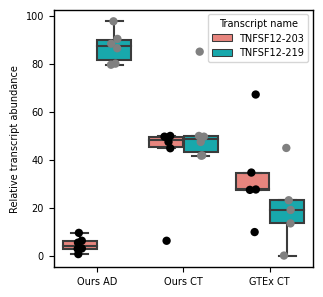

In [31]:
ax1 = sns.boxplot(df_final_relative_abundance, x="Condition", y="value", hue="variable", 
                  palette=[ggplot2_colors[0], ggplot2_colors[4]], showfliers=False)

ax2 = sns.stripplot(df_final_relative_abundance, x="Condition", y="value", hue="variable", size=6, dodge=True,
                   palette=["black", "grey"], jitter=True)


# Get the legend handles and labels for the boxplot
handles, labels = ax1.get_legend_handles_labels()

# Divide them by 2 since there will be duplicates: one for male and one for female in this case
half_length = len(handles) // 2
handles = handles[:half_length]
labels = labels[:half_length]

# Set the legend
ax1.legend(handles, labels, title='Transcript name')

plt.xlabel("")
plt.ylabel("Relative transcript abundance")


plt.savefig('../../../figures/1st_rebuttal_figures/TSNF12_external_validation/relative_abundance_boxplot.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

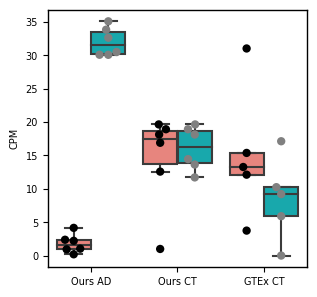

In [23]:
ax1 = sns.boxplot(df_final_cpm, x="Condition", y="value", hue="variable", 
                  palette=[ggplot2_colors[0], ggplot2_colors[4]], showfliers=False)

ax2 = sns.swarmplot(df_final_cpm, x="Condition", y="value", hue="variable", size=6, dodge=True,
                   palette=["black", "grey"])

# Set the legend
ax1.get_legend().remove()

plt.xlabel("")
plt.ylabel("CPM")

plt.savefig('../../../figures/1st_rebuttal_figures/TSNF12_external_validation/CPM_boxplot.pdf',
            dpi=600, transparent=True, bbox_inches="tight")